In [1]:
import simpy
import networkx as nx
import datetime

import itertools
import requests
import pickle
import io
import shapely
import pandas as pd
import geopandas as gpd

import simpy

import itertools

import matplotlib.pyplot as plt

import pint
ureg = pint.UnitRegistry()

In [2]:
url = 'https://zenodo.org/records/6673604/files/network_digital_twin_v0.3.pickle?download=1'
resp = requests.get(url)

In [3]:
graph = pickle.load(io.BytesIO(resp.content))
for n, node in graph.nodes.items():
    node['geometry'] = shapely.from_wkt(node['Wkt'])
    
for e, edge in graph.edges.items():
    edge['geometry'] = shapely.from_wkt(edge['Wkt'])    
    
trips_gdf = gpd.read_parquet('week_38_routes.parquet')

In [4]:
nodes = {
    "Nijmegen": "22638188",
    "Duisburg": "FN96",
    "Rotterdam": "18008346",
}

145699.13091711738

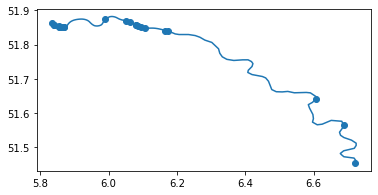

In [5]:


def get_route_gdfs(a, b):
    route = nx.shortest_path(graph, source=a, target=b, weight="length_m")


    nodes = []
    for n in route:
        node = graph.nodes[n]
        nodes.append(node)
    
    node_df = pd.DataFrame(nodes)
    geometry = gpd.GeoSeries.from_wkt(node_df['Wkt'])
    node_gdf = gpd.GeoDataFrame(node_df, geometry=geometry)

    edges = []
    for a, b in zip(route[:-1], route[1:]):
        edge = graph.edges[(a, b)].copy()
        edge_a, edge_b = edge['geometry'].boundary.geoms

        distance_a_a = edge_a.distance(graph.nodes[a]['geometry'])
        distance_a_b = edge_b.distance(graph.nodes[a]['geometry'])
        
        if distance_a_a > distance_a_b:
            edge_inverted = True
        edge['inverted'] = edge_inverted
        edges.append(edge)
        

    edge_df = pd.DataFrame(edges)
    geometry = gpd.GeoSeries.from_wkt(edge_df['Wkt'])
    
    edge_gdf = gpd.GeoDataFrame(edge_df, geometry=geometry)
    edge_gdf['geometry'] = edge_gdf.apply(lambda row: row['geometry'].reverse() if row['inverted'] else row['geometry'], axis=1)

    result = {"edge": edge_gdf, "node": node_gdf}
    return result


route_gdfs = get_route_gdfs(nodes['Nijmegen'], nodes['Duisburg'])
edge_gdf = route_gdfs["edge"]
node_gdf = route_gdfs["node"]

fig, ax = plt.subplots()

edge_gdf.plot(ax=ax)
node_gdf.plot(ax=ax)
    
edge_gdf["length_m"].sum()

In [6]:
source_gdf = trips_gdf.groupby(["source"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
target_gdf = trips_gdf.groupby(["target"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
trips_gdf_agg = trips_gdf.groupby(["route"])['v30_4_Containers_TEU_S'].agg(["sum", "count"])
trips_gdf_agg

,sum,count
route,,
Duisburg-Nijmegen,537.0,8
Duisburg-Rotterdam,18583.0,794
Nijmegen-Duisburg,473.0,7
Nijmegen-Rotterdam,5274.0,59
Rotterdam-Duisburg,23334.0,810
Rotterdam-Nijmegen,6413.0,67


In [7]:
max_capacity = trips_gdf['v30_4_Containers_TEU_S'].sum()

In [8]:
env = simpy.Environment()

In [9]:
def create_container(row, env, fill):
    if fill:
        init = row['sum']
    else:
        init = 0
    
    container = simpy.Container(env=env, capacity=max_capacity, init=init)
    return container
    
source_gdf["container"] = source_gdf.apply(create_container, env=env, fill=True, axis=1)
target_gdf["container"] = target_gdf.apply(create_container, env=env, fill=False, axis=1)
trips_gdf_agg["container"] = trips_gdf_agg.apply(create_container, env=env, fill=True, axis=1)
trips_gdf_agg

,sum,count,container
route,,,
Duisburg-Nijmegen,537.0,8,<simpy.resources.container.Container object at...
Duisburg-Rotterdam,18583.0,794,<simpy.resources.container.Container object at...
Nijmegen-Duisburg,473.0,7,<simpy.resources.container.Container object at...
Nijmegen-Rotterdam,5274.0,59,<simpy.resources.container.Container object at...
Rotterdam-Duisburg,23334.0,810,<simpy.resources.container.Container object at...
Rotterdam-Nijmegen,6413.0,67,<simpy.resources.container.Container object at...


In [10]:
trips_gdf_rotterdam_source = trips_gdf[trips_gdf['source'] == 'Rotterdam']
trip = trips_gdf_rotterdam_source.iloc[0]

In [11]:
import contextlib
COUNT = itertools.count()

class LogDecorator(contextlib.ContextDecorator):
    logbook = []
    def __init__(self, env, message, geometry, **kwargs):
        """initialize the logbook"""
        super().__init__()
        self.env = env

        self.message = message
        self.kwargs = kwargs

        self.geometry = geometry
        
        self.activity_id = next(COUNT)

    def log_entry(
        self,
        message=None,
        timestamp=None,
        value=None,
        geometry=None,
        activity_id=None,
        state=None,
        **kwargs
    ):
        timestamp = env.now
        entry = {
            "Message": message,
            "Timestamp": datetime.datetime.utcfromtimestamp(timestamp),
            "Value": value,
            "geometry": geometry,
            "ActivityID": activity_id,
            "State": state,
            "Meta": kwargs,
        }
        self.logbook.append(entry)

    def __enter__(self):
        """log a start message on entrance"""
        kwargs = {}
        kwargs.update(self.kwargs)
        self.log_entry(
            message=self.message,
            timestamp=self.env.now,
            activity_id=self.activity_id,
            geometry=self.geometry,
            state="START",
            **kwargs
        )
        return self

    def __exit__(self, *exc, **kwargs):
        """log a stop message on exit"""
        kwargs = {}
        kwargs.update(self.kwargs)        
        self.log_entry(
            message=self.message,
            timestamp=self.env.now,
            activity_id=self.activity_id,
            geometry=self.geometry,
            state="STOP",
            **kwargs
        )
        return False



In [12]:
def load(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    ship_container = trip["ship_cargo"]
    if trip["target_hub"] != trip["target"]:
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]
    
    loading_rate = 20
    with (
        source_container.get(ship_container.capacity) as get_req, 
        ship_container.put(ship_container.capacity) as put_req,
    ):
        yield get_req
        yield put_req
        yield env.timeout(ship_container.capacity * loading_rate)


def unload(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    ship_container = trip["ship_cargo"]
    if trip["target_hub"] != trip["target"]:
        route = f"{trip['target_hub']}-{trip['target']}"
        target_container = trips_gdf_agg.loc[route, "container"]
    else:
        target_container = target_gdf.loc[trip["target"], "container"]
    
    loading_rate = 20
    with (
        ship_container.get(ship_container.capacity) as get_req,
        target_container.put(ship_container.capacity) as put_req, 
    ):
        yield get_req
        yield put_req
        yield env.timeout(ship_container.capacity * loading_rate)


def move(trip, a, b):
    route_gdfs = get_route_gdfs(a, b)
    edge_gdf = route_gdfs["edge"]
    node_gdf = route_gdfs["node"]

    route_length_m = edge_gdf["length_m"].sum()
    velocity = 4
    duration = route_length_m / velocity # m / m/s = m * s / m = s
    yield env.timeout(duration)
    

def cycle(trip):
    route = f"{trip['source']}-{trip['target']}"
    source_container = trips_gdf_agg.loc[route, "container"]
    while source_container.level:
        with LogDecorator(env, message="load", geometry=trip['source_geometry'], ship=trip["ship"]):      
            yield from load(trip)
        a = nodes[trip["source"]]
        b = nodes[trip["target_hub"]]

        route_gdfs = get_route_gdfs(a, b)
        edge_gdf = route_gdfs['edge']
        geometry = edge_gdf.union_all()
        with LogDecorator(env, message="move full", geometry=geometry, ship=trip["ship"]):      
            yield from move(trip, a, b)
        with LogDecorator(env, message="unload", geometry=trip['target_hub_geometry'], ship=trip["ship"]):  
            yield from unload(trip)
        route_gdfs = get_route_gdfs(a, b)
        edge_gdf = route_gdfs['edge']
        geometry = edge_gdf.union_all()
        with LogDecorator(env, message="move empty", geometry=geometry, ship=trip["ship"]):      
            yield from move(trip, a, b)
 

In [13]:

ships = ["RTM-NIJ"]
for ship in ships:
    trip = {
        "source": "Rotterdam",
        "target": "Duisburg",
        "target_hub": "Nijmegen",
        "ship_cargo": simpy.Container(env, capacity=200, init=0),
        "ship": ship
    }
    
    trip["source_geometry"] = graph.nodes[nodes[trip["source"]]]['geometry']
    trip["target_geometry"] = graph.nodes[nodes[trip["target"]]]['geometry']
    trip["target_hub_geometry"] = graph.nodes[nodes[trip["target_hub"]]]['geometry']
    trip
    env.process(cycle(trip))

more_ships = ["NIJ-DUI"]
for ship in more_ships:
    trip = {
        "source": "Nijmegen",
        "target": "Duisburg",
        "target_hub": "Duisburg",
        "ship_cargo": simpy.Container(env, capacity=200, init=0),
        "ship": ship
    }
    
    trip["source_geometry"] = graph.nodes[nodes[trip["source"]]]['geometry']
    trip["target_geometry"] = graph.nodes[nodes[trip["target"]]]['geometry']
    trip["target_hub_geometry"] = graph.nodes[nodes[trip["target_hub"]]]['geometry']
    trip
    env.process(cycle(trip))

env.run()

In [14]:
log_df = pd.DataFrame(LogDecorator.logbook)
log_df['Ship'] = log_df['Meta'].apply(lambda x: x['ship'])

In [15]:
gantt_df = log_df.query("Message == 'move full'").pivot(index="ActivityID", columns="State")


In [16]:
log_df.query("Message == 'move full' and State == 'START'").groupby('Ship').count()

,Message,Timestamp,Value,geometry,ActivityID,State,Meta
Ship,,,,,,,
NIJ-DUI,118,118,0,118,118,118,118
RTM-NIJ,116,116,0,116,116,116,116


In [17]:
log_df

,Message,Timestamp,Value,geometry,ActivityID,State,Meta,Ship
0,load,1970-01-01 00:00:00.000000,None,POINT (3.98266103292731 51.9406397519052),0,START,{'ship': 'RTM-NIJ'},RTM-NIJ
1,load,1970-01-01 00:00:00.000000,None,POINT (5.8340360338013 51.86191553483061),1,START,{'ship': 'NIJ-DUI'},NIJ-DUI
2,load,1970-01-01 01:06:40.000000,None,POINT (3.98266103292731 51.9406397519052),0,STOP,{'ship': 'RTM-NIJ'},RTM-NIJ
3,move full,1970-01-01 01:06:40.000000,None,MULTILINESTRING ((3.98266103292731 51.94063975...,2,START,{'ship': 'RTM-NIJ'},RTM-NIJ
4,load,1970-01-01 01:06:40.000000,None,POINT (5.8340360338013 51.86191553483061),1,STOP,{'ship': 'NIJ-DUI'},NIJ-DUI
...,...,...,...,...,...,...,...,...
1869,move empty,1970-06-10 17:49:42.606354,None,MULTILINESTRING ((5.8340360338013 51.861915534...,935,START,{'ship': 'NIJ-DUI'},NIJ-DUI
1870,move empty,1970-06-10 22:08:07.511173,None,MULTILINESTRING ((3.98266103292731 51.94063975...,932,STOP,{'ship': 'RTM-NIJ'},RTM-NIJ
1871,load,1970-06-10 22:08:07.511173,None,POINT (3.98266103292731 51.9406397519052),936,START,{'ship': 'RTM-NIJ'},RTM-NIJ
1872,move empty,1970-06-11 03:56:47.389084,None,MULTILINESTRING ((5.8340360338013 51.861915534...,935,STOP,{'ship': 'NIJ-DUI'},NIJ-DUI
